In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
import torch
from torch import nn
import pandas as pd
import torchvision.transforms as T
from torch.utils.data import TensorDataset
import pickle
import io
from sklearn.metrics import r2_score, mean_squared_error

import os, sys
root_path = root_path = os.path.realpath('../')
try:
    import ego_allo_rnns
except ModuleNotFoundError:
    sys.path.append(root_path)

from ego_allo_rnns.data.EgoVsAllo import make_testset_from_conditions, make_datasets

In [57]:
results_dir = '../checkpoints/'
conditions = ["WCWC","SCWC","SCSC","WCSC"]
n_runs = 20

## Preprocessing
First we need to create a test set of the 24 conditions we're interested in and feed it through each of the trained RNNs.  
We can also log metrics such as MSE and $R^2$ while we're at it

In [17]:


device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


testset_results = {}
for cond in conditions:
    df, data_test = make_testset_from_conditions(random_seed=123,input_type=cond[:2],output_type=cond[2:])
    testset_results[cond] = {"predictions": [],
    "ground_truth" : [],
    "hidden_activity" : [],}
    for run_id in range(n_runs):
        # load model
        with open(f"{results_dir}run_{cond}_{run_id+1}/model.pkl", "rb") as f:
            rnn = pickle.load(f)
        
        predictions = []
        ground_truth = []
        hidden_activity = []
        rnn.to(device)
        for x,y in data_test:
            y_ = rnn.forward(x.reshape(1,11,1600).to(device))
            y_ = y_.to("cpu").detach().numpy()
            predictions.append(y_)
            ground_truth.append(y.to("cpu").detach().numpy())
            hidden_activity.append(rnn.ro.to("cpu").detach().numpy())
        testset_results[cond]["ground_truth"].append(np.asarray(ground_truth))
        testset_results[cond]["predictions"].append(np.asarray(predictions).squeeze())
        testset_results[cond]["hidden_activity"].append(np.asarray(hidden_activity).squeeze())
    for k, v in testset_results[cond].items():
        testset_results[cond][k] = np.asarray(v)

### Performance
- Learning curves
- $R^2$ metric
- visualisation of test set accuracy

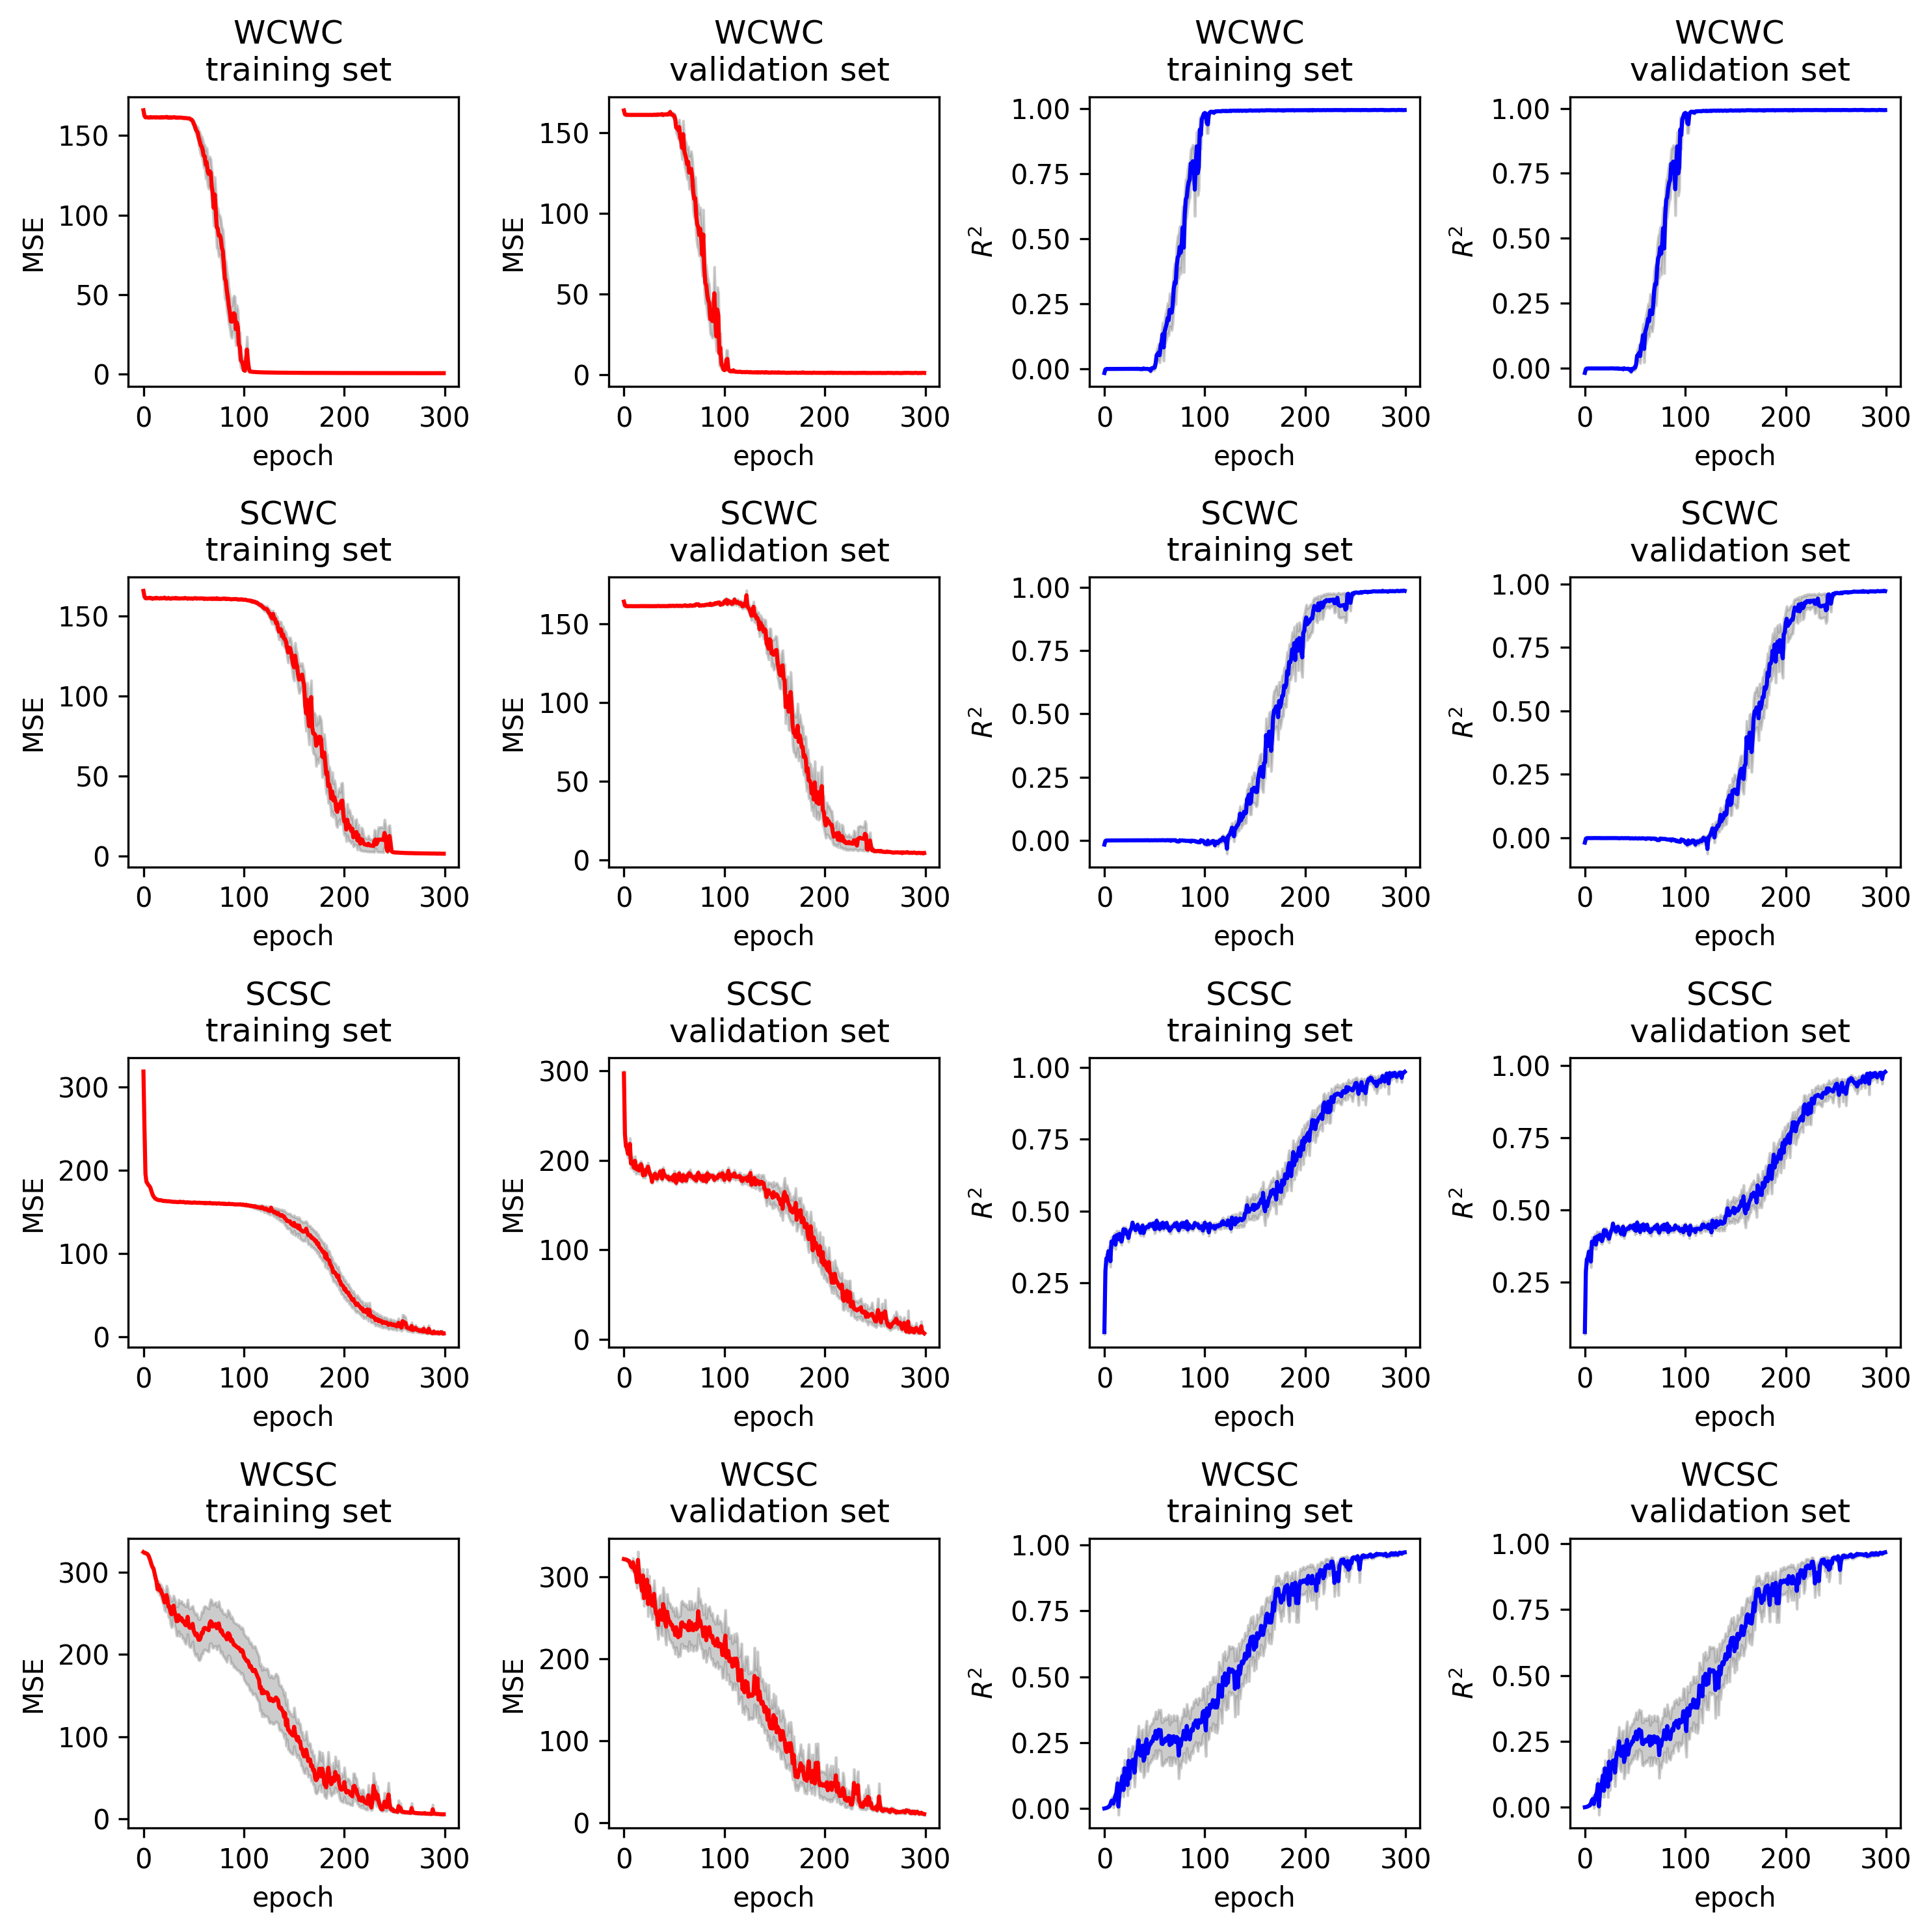

In [58]:
# Learning Curves
lcurves = dict()
for i in conditions:
    lcurves[i] = {
        "losses": {"training": [], "validation": []},
        "r_squared": {"training": [], "validation": []},
    }

    for j in range(n_runs):        
        with open(f"{results_dir}run_{i}_{j+1}/training_results.pkl", "rb") as f:
            data = pickle.load(f)
        for k1 in data.keys():
            for k2 in data[k1].keys():
                lcurves[i][k1][k2].append(data[k1][k2])

# subplots: 4 rows (io conditions) by 4 columns (loss (train,val), r-squared(train,val))
f,axs = plt.subplots(4,4,figsize=(10,10),dpi=300)
axs = axs.flatten()

ax_id = 0

sem = lambda x,dim: np.std(x,dim)/np.sqrt(x.shape[dim])
for cond in conditions:
    for measure in lcurves[cond].keys():
        for ds in lcurves[cond][measure].keys():            
            y = np.asarray(lcurves[cond][measure][ds])            
            x = np.arange(y.shape[1])
            y_mu = np.mean(y,0)
            y_err = sem(y,0)
            axs[ax_id].plot(x,y_mu,'r-' if measure=="losses" else "b-")
            axs[ax_id].fill_between(x, y_mu-y_err,y_mu+y_err,color="grey",alpha=0.4)
            if measure == "losses":
                measure_label = "MSE"
            elif measure == "r_squared":
                measure_label = r"$R^2$"
            axs[ax_id].set(xlabel="epoch",ylabel=measure_label,title=f"{cond} \n {ds} set")
            ax_id +=1
plt.tight_layout()
            


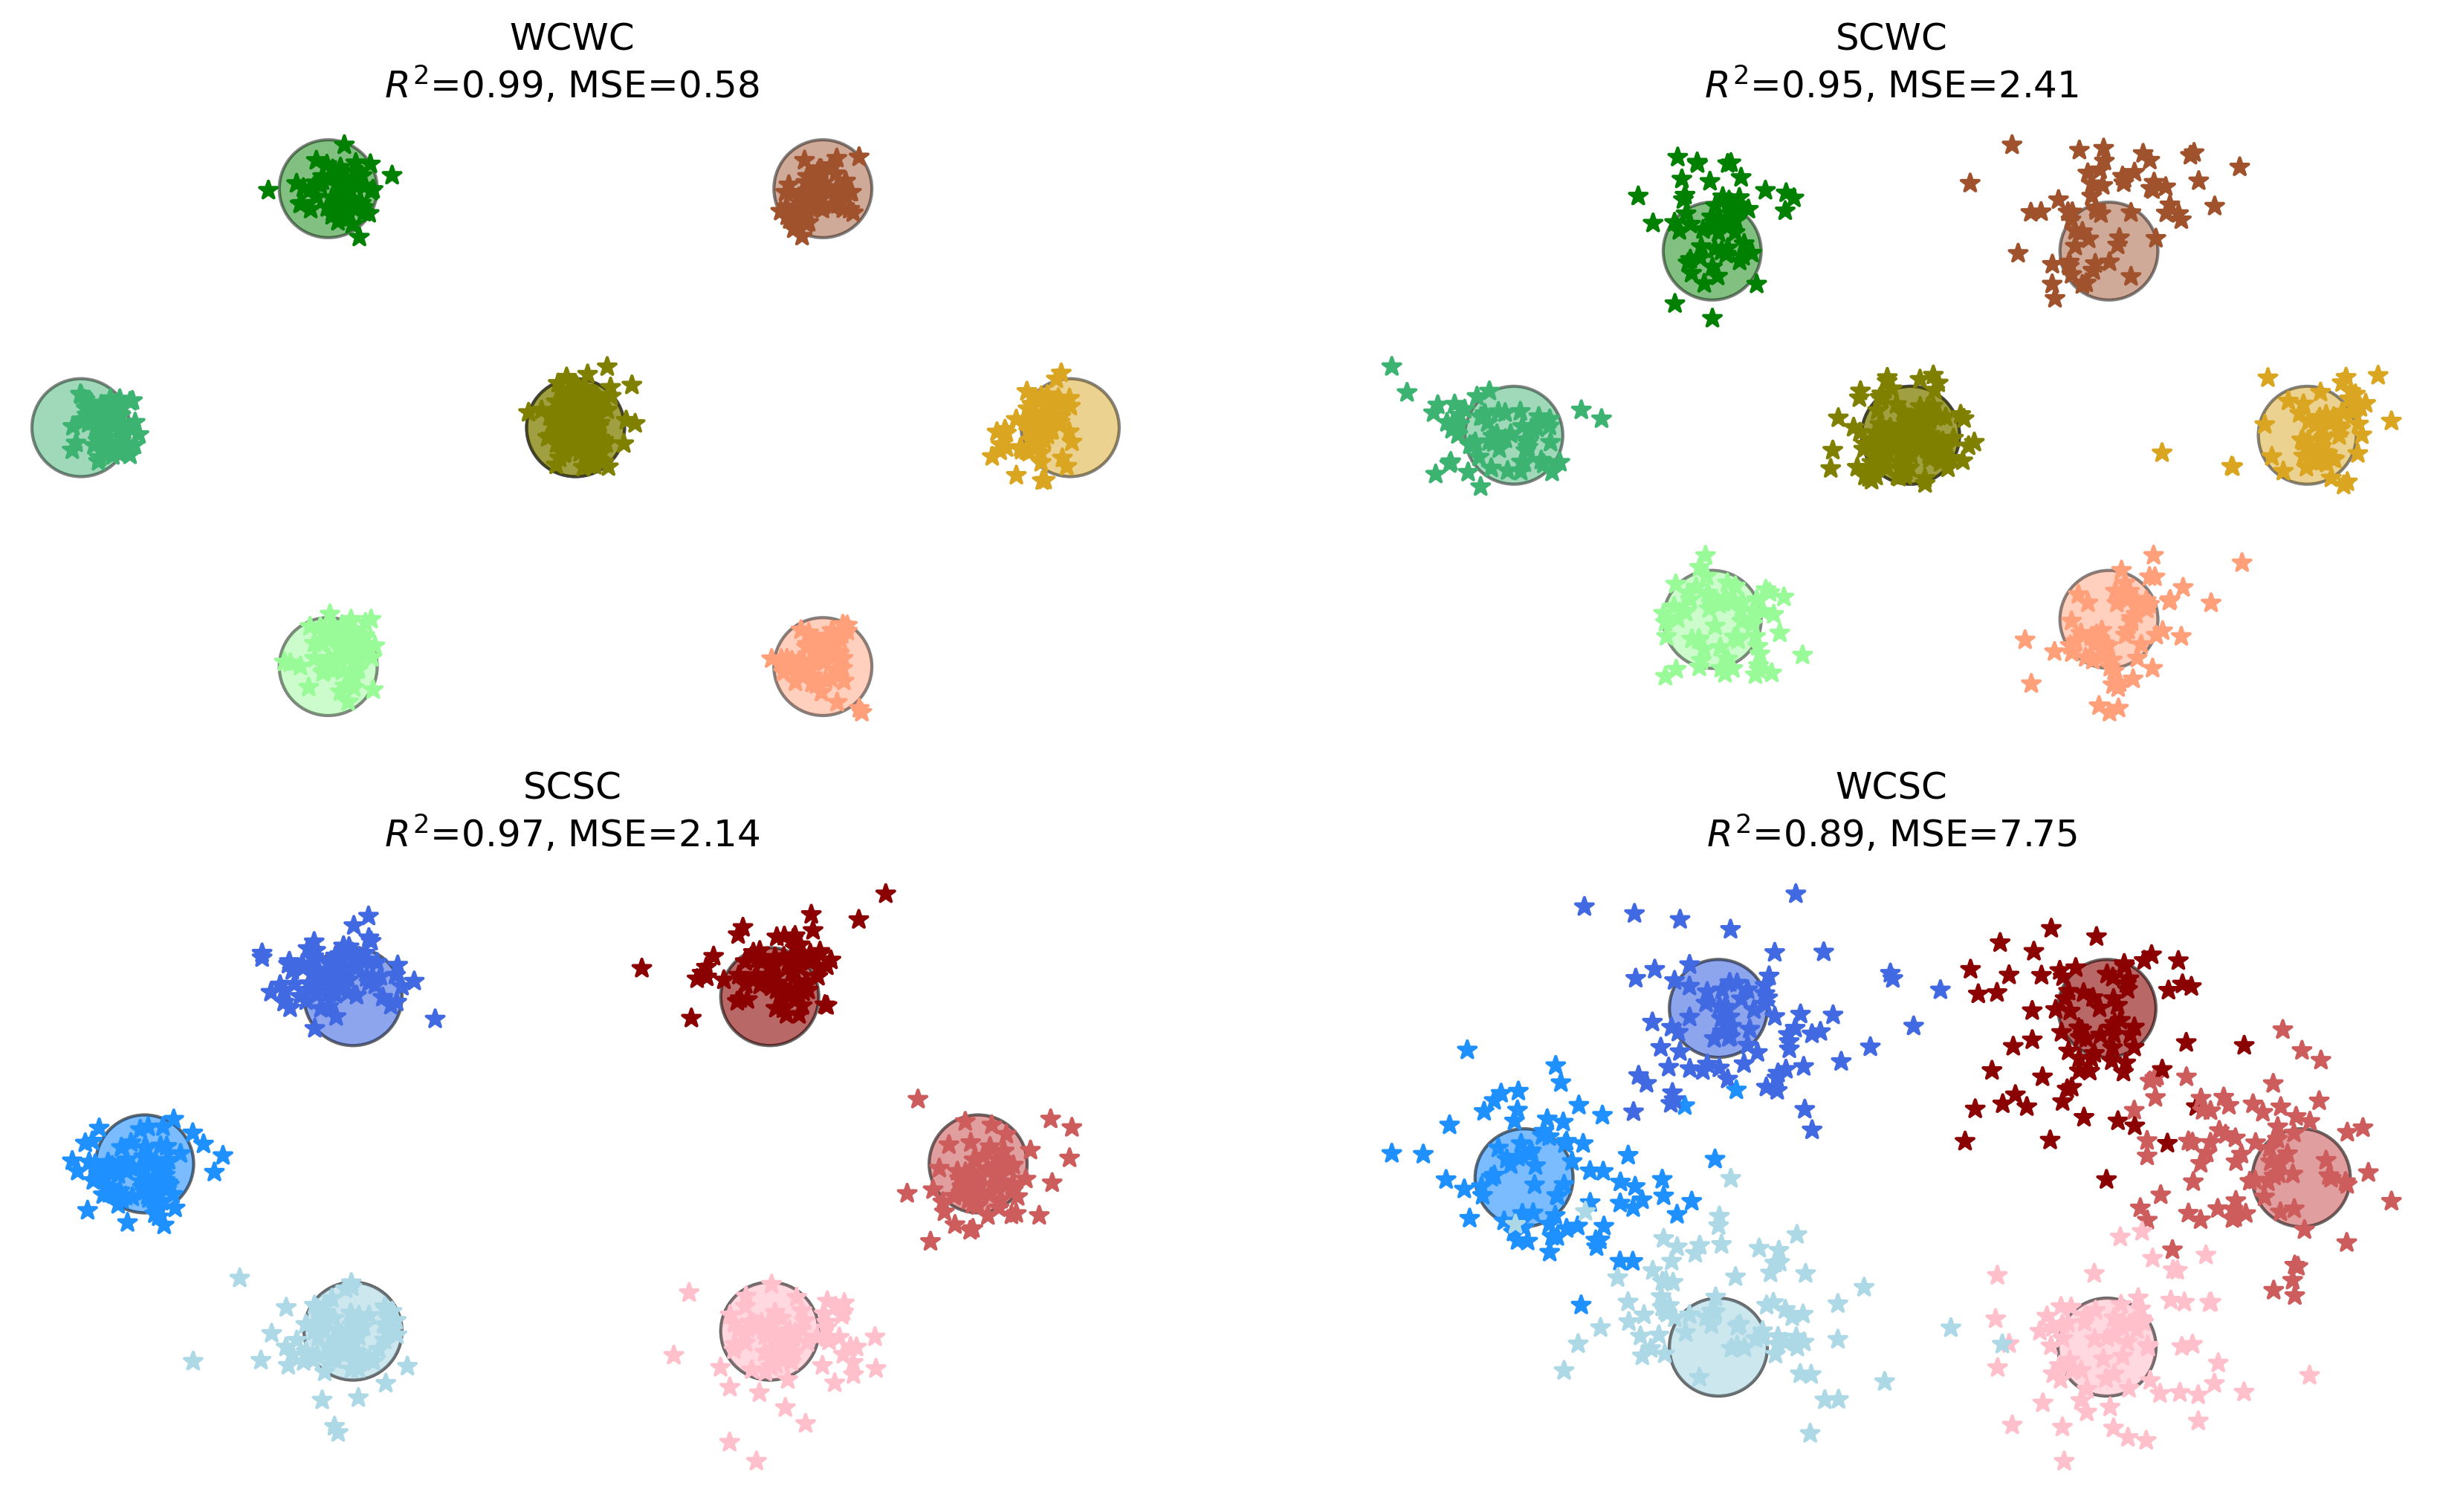

In [70]:
# test set performance
f, axs = plt.subplots(2,2,figsize=(14,8),dpi=300)
axs = axs.flatten()
labels = ["target_loc_color","target_loc_color","target_direction_color","target_direction_color"]

for ax,cond,label in zip(axs,conditions,labels):
    
    target_colors = df[label]
    coords_gt = testset_results[cond]["ground_truth"][0,:,[1,0]]
    ax.scatter(*coords_gt,s=1000,marker='o',c=target_colors.to_numpy(),edgecolor='k',alpha=0.2)
    for run_id in range(n_runs):    
        coords_pred = testset_results[cond]["predictions"][run_id,:,[1,0]]
        ax.scatter(*coords_pred,marker="*",c=target_colors.to_numpy())

    r2 = r2_score(testset_results[cond]["ground_truth"].reshape(n_runs*24,2),testset_results[cond]["predictions"].reshape(n_runs*24,2),multioutput="uniform_average")
    mse = mean_squared_error(testset_results[cond]["ground_truth"].reshape(n_runs*24,2),testset_results[cond]["predictions"].reshape(n_runs*24,2),multioutput="uniform_average")
    ax.set_axis_off()
    ax.set_title(cond+"\n"+r"$R^2$="+f"{r2:.2f}, MSE={mse:.2f}")
    

### Hidden Layer patterns

In [ ]:
#TODO 